Data
- https://www.cs.utexas.edu/~rofuyu/papers/tr-mf-nips.pdf
- https://files.stlouisfed.org/files/htdocs/conferences/2014-nber-nsf/docs/papers/Nicholson,%20Will.pdf

Blogs
- https://medium.com/slalom-technology/failing-fast-with-deepar-neural-networks-for-time-series-ef442bf03567

Do deep nets need to be so deep
- https://arxiv.org/abs/1312.6184
- https://arxiv.org/abs/1312.6184

# Goals

- model should reduce to fb prophet when some input parameter is 1 (e.g. number of layers) and before any link functions are applied. In other words, fb prophet should be a special case
- support arbitrary loss functions
- support multi-parameter distribution modeling
- can we incorporate https://en.wikipedia.org/wiki/Discrete-time_Fourier_transform
- demonstrate generalization to new "items" (IDs) via collaborative layers
- maybe offset the `t` in seasonal layers with the trend embedding

# TODO:

- simulated data
- try overfitting to a single house
- try different data set: parts or https://www.kaggle.com/c/web-traffic-time-series-forecasting

In [1]:
# https://statmodeling.stat.columbia.edu/2013/12/19/happy-birthday/
# https://fivethirtyeight.com/features/some-people-are-too-superstitious-to-have-a-baby-on-friday-the-13th/

import pandas as pd
from fbprophet import Prophet

df = pd.read_csv('../prophet-the-rf-of-timeseries/US_births_2000-2014_SSA.csv')
df.head()

,year,month,date_of_month,day_of_week,births
0,2000,1,1,6,9083
1,2000,1,2,7,8006
2,2000,1,3,1,11363
3,2000,1,4,2,13032
4,2000,1,5,3,12558


In [2]:
df['ds'] = pd.to_datetime(df.drop(['day_of_week', 'births'], axis=1).rename({'date_of_month': 'day'}, axis=1))
df.head()

,year,month,date_of_month,day_of_week,births,ds
0,2000,1,1,6,9083,2000-01-01
1,2000,1,2,7,8006,2000-01-02
2,2000,1,3,1,11363,2000-01-03
3,2000,1,4,2,13032,2000-01-04
4,2000,1,5,3,12558,2000-01-05


In [3]:
T0 = pd.Timestamp(0)
df['t'] = (df.ds - T0).dt.total_seconds() / (60 * 60 * 24)

In [4]:
df['id'] = 0

In [5]:
df.head()

,year,month,date_of_month,day_of_week,births,ds,t,id
0,2000,1,1,6,9083,2000-01-01,10957.0,0
1,2000,1,2,7,8006,2000-01-02,10958.0,0
2,2000,1,3,1,11363,2000-01-03,10959.0,0
3,2000,1,4,2,13032,2000-01-04,10960.0,0
4,2000,1,5,3,12558,2000-01-05,10961.0,0


# Inspect

In [6]:
%run stl

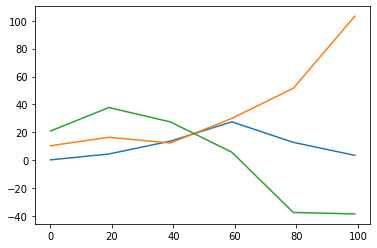

In [7]:
import matplotlib.pyplot as plt
import numpy as np

c = 5
d = np.repeat(np.random.normal(size=(1, 3, c)), 100, axis=0)
s = np.arange(c, dtype='float32') * 20
t = np.arange(100, dtype='float32')[:, None] + 1.

plt.plot(
    CallaborativeLinearTrendEmbedding.trend(
        d,
        np.arange(3) * 10,
        np.ones(3),
        s,
        t,
    ).numpy()
)

In [8]:
# import numpy as np
# import tensorflow as tf


# class SeasonalEmbedding(tf.keras.layers.Layer):
#     def __init__(self, *args, input_dim, period, N, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.input_dim = input_dim
#         self.period = period
#         self.N = N
#         # model params
#         self.a_n, self.b_n = [tf.keras.layers.Embedding(input_dim=input_dim, output_dim=N, input_length=1)] * 2


#     def call(self, input_tensor, training=False):
#         id, t = input_tensor
#         n = (tf.range(self.N, dtype='float') + 1)[None, :]

#         instance_trend = self.fourier_series(
#             tf.squeeze(self.a_n(id), axis=1),
#             tf.squeeze(self.b_n(id), axis=1),
#             t,
#             n,
#             self.period)
#         global_trend = self.fourier_series(
#             tf.squeeze(self.a_n(tf.zeros_like(id)), axis=1),
#             tf.squeeze(self.b_n(tf.zeros_like(id)), axis=1),
#             t,
#             n,
#             self.period)
        
#         return instance_trend + global_trend

#     @staticmethod
#     def fourier_series(a_n, b_n, t, n, period):
#         x = (2 * np.pi * tf.multiply(t, n)) / period
#         return (
#             tf.reduce_sum(tf.multiply(tf.cos(x), a_n), axis=1, keepdims=True)
#             + tf.reduce_sum(tf.multiply(tf.sin(x), b_n), axis=1, keepdims=True)
#         )
    

# class SeasonalEmbeddingWithMovement(tf.keras.layers.Layer):
#     def __init__(self, *args, period, N, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.period = period
#         self.N = N
#         # model params
#         self.a_n, self.b_n = [tf.keras.layers.Dense(self.N, activation='linear')] * 2

#     def call(self, input_tensor, training=False):
#         X, t = input_tensor
#         n = (tf.range(self.N, dtype='float') + 1)[None, :]

#         return self.fourier_series(
#             self.a_n(X),
#             self.b_n(X),
#             n,
#             self.period,
#             t)

#     @staticmethod
#     def fourier_series(a_n, b_n, n, period, t):
#         x = (2 * np.pi * tf.multiply(t, n)) / period
#         return (
#             tf.reduce_sum(tf.multiply(tf.cos(x), a_n), axis=1, keepdims=True)
#             + tf.reduce_sum(tf.multiply(tf.sin(x), b_n), axis=1, keepdims=True)
#         )


# class LinearTrendEmbedding(tf.keras.layers.Layer):
#     def __init__(self, *args, input_dim, max_t, n_changepoints=25, checkpoint_range=.8, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.input_dim = input_dim
#         self.max_t = max_t
#         self.n_changepoints = n_changepoints
#         self.checkpoint_range = checkpoint_range
#         self.δ = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=self.n_changepoints * 3, input_length=1,
#                                            # l1 imitates Laplace prior from Prophet model
#                                            embeddings_regularizer='l1')
#         self.m = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=1, input_length=1)
#         self.k = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=1, input_length=1)

#     def build(self, input_shape):
#         self.s = tf.cast(tf.linspace(0, int(self.checkpoint_range * self.max_t), self.n_changepoints + 1), 'float')[1:]

#     def call(self, input_tensor, training=False):
#         id, t = input_tensor
        
#         instance_trend = self.trend(
#             tf.reshape(tf.squeeze(self.δ(id), axis=1), (-1, self.n_changepoints, 3)),
#             tf.reshape(tf.squeeze(self.m(id), axis=1), (-1, self.n_changepoints, 3)),
#             tf.reshape(tf.squeeze(self.k(id), axis=1), (-1, self.n_changepoints, 3)),
#             self.s,
#             t)
        
#         global_trend = self.trend(
#             tf.reshape(tf.squeeze(self.δ(tf.zeros_like(id)), axis=1), (-1, self.n_changepoints, 3)),
#             tf.reshape(tf.squeeze(self.m(tf.zeros_like(id)), axis=1), (-1, self.n_changepoints, 3)),
#             tf.reshape(tf.squeeze(self.k(tf.zeros_like(id)), axis=1), (-1, self.n_changepoints, 3)),
#             self.s,
#             t)

#         return instance_trend + global_trend

#     @staticmethod
#     def trend(δ, m, k, s, t):
#         A = tf.cast((t > s), 'float')

#         trend = tf.reduce_sum(tf.multiply(A, δ), axis=-1) * t + k

#         γ = tf.multiply(-s, δ)
#         offset = tf.reduce_sum(tf.multiply(A, γ), axis=-1) + m

#         return trend + offset
    
    
# class LinearTrendEmbeddingWithMovement(tf.keras.layers.Layer):
#     def __init__(self, *args, t_range, n_changepoints=25, checkpoint_range=.8, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.t_range = t_range
#         self.n_changepoints = n_changepoints
#         self.checkpoint_range = checkpoint_range
#         self.r = tf.keras.layers.Reshape((3, self.n_changepoints))
#         self.δ = tf.keras.layers.Dense(self.n_changepoints * 3, kernel_regularizer='l1')
#         self.m = tf.keras.layers.Dense(1)
#         self.k = tf.keras.layers.Dense(1)

#     def build(self, input_shape):
#         self.s = tf.cast(tf.linspace(self.t_range[0], int(self.checkpoint_range * self.t_range[1]), self.n_changepoints + 1), 'float')[1:]

#     def call(self, input_tensor, training=False):
#         X, t = input_tensor
#         return self.trend(
#             self.r(self.δ(X)),
#             self.m(X),
#             self.k(X),
#             self.s,
#             t)

#     @staticmethod
#     def trend(δ, m, k, s, t):
#         A = tf.cast((t > s), 'float')[:, None, :]

#         trend = (tf.reduce_sum(tf.multiply(A, δ), axis=-1) + k) * t

#         γ = tf.multiply(-s[None, None, :], δ)
#         offset = tf.reduce_sum(tf.multiply(A, γ), axis=-1) + m

#         return trend + offset
    

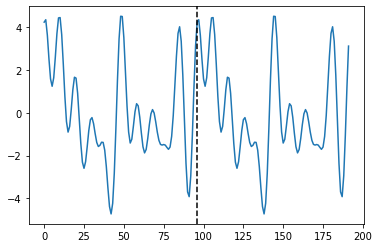

In [9]:
order = 10

plt.plot(
    CallaborativeSeasonalEmbedding.fourier_series(
        np.random.normal(size=order),
        np.random.normal(size=order),
        np.arange(order, dtype='float32') + 1,
        24,
        np.arange(192, dtype='float32')[:, None] / 4
    ).numpy().ravel()
)

plt.gca().axvline(96, ls='--', color='k')

# Model

In [147]:
%run stl.py


n_items = 1
t_range = df.t.min(), df.t.max()

model = STL(
    n_items=n_items,
    embedding_dim=None,
    n_inner_layers=None,
    n_outer_layers=2,
    trend_dim=1,
    n_changepoints=20,
    checkpoint_range=.8,
    t0=None,
    t_range=t_range,
    periods=[(7, 3), (365.25, 10)],
    output_activations='linear',
)

model._model.compile(loss='mse', optimizer='adam')

In [148]:
model._model.summary()

Model: "model_64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
id (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_84 (Embedding)        (None, 1, 3)         3           id[0][0]                         
__________________________________________________________________________________________________
embedding_86 (Embedding)        (None, 1, 3)         3           id[0][0]                         
__________________________________________________________________________________________________
embedding_85 (Embedding)        (None, 1, 10)        10          id[0][0]                         
___________________________________________________________________________________________

In [149]:
Xt = df[['id', 't']].to_dict('series')
model._model.fit(
    Xt, df.births,
    batch_size=32,
    epochs=50
)

Epoch 1/50
172/172 [==============================] - 1s 996us/step - loss: 109798612.0231
Epoch 2/50
172/172 [==============================] - 0s 995us/step - loss: 29723053.0751
Epoch 3/50
172/172 [==============================] - 0s 925us/step - loss: 12859038.0636
Epoch 4/50
172/172 [==============================] - 0s 1ms/step - loss: 5587274.6127
Epoch 5/50
172/172 [==============================] - 0s 1ms/step - loss: 5318157.0954
Epoch 6/50
172/172 [==============================] - 0s 1ms/step - loss: 5085177.3728
Epoch 7/50
172/172 [==============================] - 0s 1ms/step - loss: 5014716.6185
Epoch 8/50
172/172 [==============================] - 0s 986us/step - loss: 4679199.8208
Epoch 9/50
172/172 [==============================] - 0s 1ms/step - loss: 4262041.1012
Epoch 10/50
172/172 [==============================] - 0s 1ms/step - loss: 3909756.0867
Epoch 11/50
172/172 [==============================] - 0s 992us/step - loss: 3399711.2934
Epoch 12/50
172/172 [======

In [150]:
df['p'] = model._model.predict(Xt)

<AxesSubplot:>

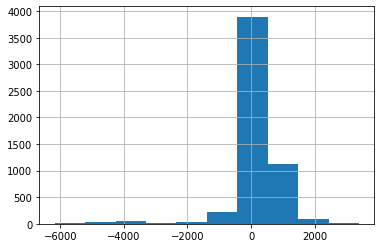

In [151]:
(df.births - df.p).hist()

<AxesSubplot:xlabel='t'>

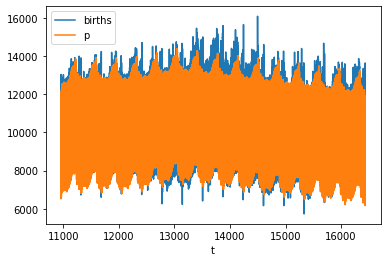

In [152]:
df.set_index('id').set_index('t')[['births', 'p']].plot()


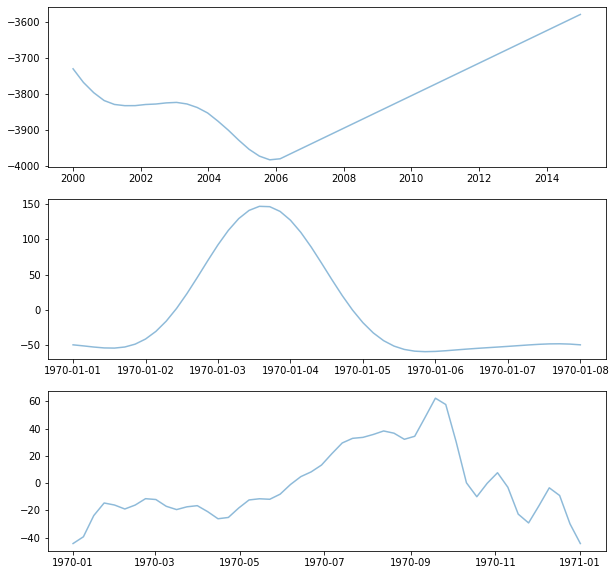

In [153]:
model.plot()